In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import random
import seaborn as sns
sns.set(style="whitegrid")
import collections 
import itertools
import collections

In [2]:
import sys
import time
def print_statusline(msg: str):
    last_msg_length = len(print_statusline.last_msg) if hasattr(print_statusline, 'last_msg') else 0
    print(' ' * last_msg_length, end='\r')
    print(msg, end='\r')
    sys.stdout.flush()  # Some say they needed this, I didn't.
    print_statusline.last_msg = msg

## Problem 1.1 - Epidemics over symmetric graphs

You should simulate an epidemic on a symmetric k-regular graph with 500 nodes and k = 4. Let $\beta=3$ and $\rho$=0.7.
With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

$\rho$ is the probability that at one time step an infected I individual recovers becoming state R (mutation kernel).

$\beta$ is the probability that a susceptible S becomes and infected I based on the number of infected neighbors.

In [3]:
def draw_k_symmetric(n=8,k=4):
    G = nx.Graph()
    for i in range(n-2):
        G.add_edge(i, i+1)
        G.add_edge(i, i+2)
    G.add_edge(n-2, n-1)
    G.add_edge(n-2, 0)
    G.add_edge(n-1, 0)
    G.add_edge(n-1, 1)
    
    #nx.draw_circular(G, with_labels = True)
    
    return G

G = draw_k_symmetric(500)
print(G)

Graph with 500 nodes and 1000 edges


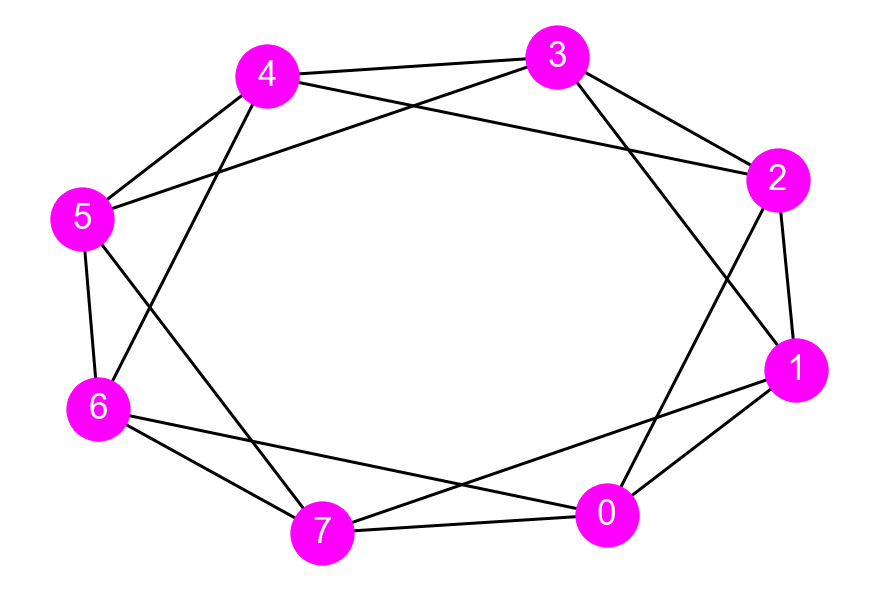

In [4]:
fig = plt.figure(1, figsize=(12,8))
G6 = draw_k_symmetric(8)
pos = nx.spring_layout(G6, seed= 13)
nx.draw(G6, pos, with_labels = True, font_color='white', node_color='magenta', 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35)
plt.savefig('01symmetric.png', bbox_inches='tight')

In [5]:
def simulate_epidemics(graph, n_infected=10, beta=0.3, rho=0.7, n_weeks=15, n_simulation=100,
                      flg_vaccine = False, 
                      vax_campaign = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]):
    
    # S=0, I=1, R=2
    G = graph
    # Number of agents, the number of nodes in the graph
    n_agents = len(G)

    tot_susceptible = np.zeros(n_weeks, dtype=int)
    tot_infected = np.zeros(n_weeks, dtype=int)
    tot_recovered = np.zeros(n_weeks, dtype=int)
    tot_new_infection = np.zeros(n_weeks, dtype=int)
    
    if flg_vaccine == True:
        fract_to_vax = [abs(prev-succ) for prev, succ in zip(vax_campaign, vax_campaign[1:])] 
        tot_vaccinated = np.zeros(n_weeks, dtype=int)
        tot_new_vaccinated = np.zeros(n_weeks, dtype=int)

    for i in range(n_simulation):
        # Initial configuration with random 10 infected nodes
        status = np.zeros(n_agents, dtype=int)
        initial_contagion = random.sample(list(np.arange(n_agents)), n_infected)
        for ix in initial_contagion:
            status[ix] = 1

        susceptible = []
        infected = []
        recovered = []
        new_infection = []
        
        if flg_vaccine == True:
            vaccinated = []
            new_vaccination = []         

        curr_state = status.copy()

        for week in range(n_weeks):
            prev_state = curr_state.copy()
            #print("week: ", week)
            #print(prev_state)
            #print("suscep: ", len(np.argwhere(prev_state == 0)))
            #print("infect: ", len(np.argwhere(prev_state == 1)))
            #print("recove: ", len(np.argwhere(prev_state == 2)))
            #print("vaccin: ", len(np.argwhere(prev_state == 3)))
            #print()
            
            if flg_vaccine == True:
                new_vax = 0
                not_vaccinated = np.argwhere(prev_state!=3).squeeze()
                number_to_vax = round(n_agents/100*fract_to_vax[week])
                people_to_vax = np.random.choice(not_vaccinated, size=number_to_vax, replace=False)
                for p in people_to_vax:
                    prev_state[p] = 3
                    new_vax += 1
                new_vaccination.append(new_vax)                
        
            curr_state = prev_state.copy()
            
            #print(curr_state)
            #print("suscep: ", len(np.argwhere(curr_state == 0)))
            #print("infect: ", len(np.argwhere(curr_state == 1)))
            #print("recove: ", len(np.argwhere(curr_state == 2)))
            #print("vaccin: ", len(np.argwhere(curr_state == 3)))
            #print(len(np.argwhere(curr_state == 0))+len(np.argwhere(curr_state == 1))+len(np.argwhere(curr_state == 2))+len(np.argwhere(curr_state == 3)))
            #print()
            
            susceptible.append(len(np.argwhere(curr_state == 0)))
            infected.append(len(np.argwhere(curr_state == 1)))
            recovered.append(len(np.argwhere(curr_state == 2)))
            if flg_vaccine == True:
                vaccinated.append(len(np.argwhere(curr_state == 3)))
            
            new_infect = 0      
            for node in range(n_agents):
                # If the node is susceptible
                if prev_state[node] == 0:
                    # compute the number of infected neighbors
                    neighbors = [i for i in G.neighbors(node)]
                    infect = sum(list(filter(lambda k:k==1, prev_state[neighbors])))
                    # compute the probability of infection
                    prob_infection = 1 - (1-beta)**infect
                    if np.random.rand() < prob_infection:
                        # infected!
                        curr_state[node] = 1
                        new_infect += 1
                # If the node is infected
                elif prev_state[node] == 1:
                    # probability of recover is rho = 0.7
                    if np.random.rand() < rho:
                        # recoved!
                        curr_state[node] = 2
            new_infection.append(new_infect)


        tot_susceptible = [sum(s) for s in zip(tot_susceptible, susceptible)]
        tot_infected = [sum(s) for s in zip(tot_infected, infected)]
        tot_recovered = [sum(s) for s in zip(tot_recovered, recovered)]
        tot_new_infection = [sum(s) for s in zip(tot_new_infection, new_infection)]
        if flg_vaccine == True:
            tot_vaccinated = [sum(s) for s in zip(tot_vaccinated, vaccinated)]
            tot_new_vaccinated = [sum(s) for s in zip(tot_new_vaccinated, new_vaccination)]

    avg_susceptible = [x/n_simulation for x in tot_susceptible]
    avg_infected = [x/n_simulation for x in tot_infected]
    avg_recovered = [x/n_simulation for x in tot_recovered]
    avg_new_infection = [x/n_simulation for x in tot_new_infection]
    if flg_vaccine == True:
        avg_vaccinated = [x/n_simulation for x in tot_vaccinated]
        avg_new_vaccinated = [x/n_simulation for x in tot_new_vaccinated]
        
    if flg_vaccine == True:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection, avg_vaccinated, avg_new_vaccinated
    else:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection

In [6]:
def epidemics_statistics(n_week, avg_susceptible, avg_infected, avg_recovered, avg_new_infection,
                         avg_vaccinated=[],avg_new_vaccinated=[],flg_vaccine = False):

    print("avg susceptible:")
    print(avg_susceptible)
    print("avg infected:")
    print(avg_infected)
    print("avg recovered:")
    print(avg_recovered)
    
    if flg_vaccine == True:
        print("avg vaccinated:")
        print(avg_vaccinated)
        
    print("avg new infection:")
    print(avg_new_infection)
    
    if flg_vaccine == True:
        print("avg new vaccinated:")
        print(avg_new_vaccinated)
           
    fig, (ax1, ax2)= plt.subplots(2,1,figsize=(15,12))
    x = list(np.arange(1, 16))
    ax1.set_xticks(x)
    ax2.set_xticks(x)               
    #plt.plot(x, avg_susceptible, label="average susceptible") 
    ax1.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
    ax1.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
    ax1.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3) 
    if flg_vaccine == True:
        ax2.plot(x, avg_vaccinated, label="average vaccinated", color = 'darkviolet', 
                 linestyle='dashed', linewidth=3)
        ax2.plot(x, avg_new_vaccinated, label="average new vaccinated", color = 'darkorange',
                 linestyle='dashed', linewidth=3)

    ax1.tick_params(axis='x', labelsize=17)
    ax1.tick_params(axis='y', labelsize=17)
    ax1.legend(fontsize=17)

    if flg_vaccine == True:
        ax2.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
        ax2.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
        ax2.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3)     
    else:
        ax2.plot(x, avg_susceptible, label="average susceptible", color = 'blue', linewidth=3)
    ax2.tick_params(axis='x', labelsize=17)
    ax2.tick_params(axis='y', labelsize=17)
    ax2.legend(fontsize=17)

    plt.show()

avg susceptible:
[490.0, 478.39, 468.34, 460.7, 454.94, 450.92, 447.78, 445.64, 444.19, 443.24, 442.41, 441.82, 441.56, 441.31, 441.16]
avg infected:
[10.0, 14.59, 14.19, 12.06, 9.19, 6.59, 5.01, 3.56, 2.61, 1.74, 1.23, 1.02, 0.56, 0.47, 0.27]
avg recovered:
[0.0, 7.02, 17.47, 27.24, 35.87, 42.49, 47.21, 50.8, 53.2, 55.02, 56.36, 57.16, 57.88, 58.22, 58.57]
avg new infection:
[11.61, 10.05, 7.64, 5.76, 4.02, 3.14, 2.14, 1.45, 0.95, 0.83, 0.59, 0.26, 0.25, 0.15, 0.11]


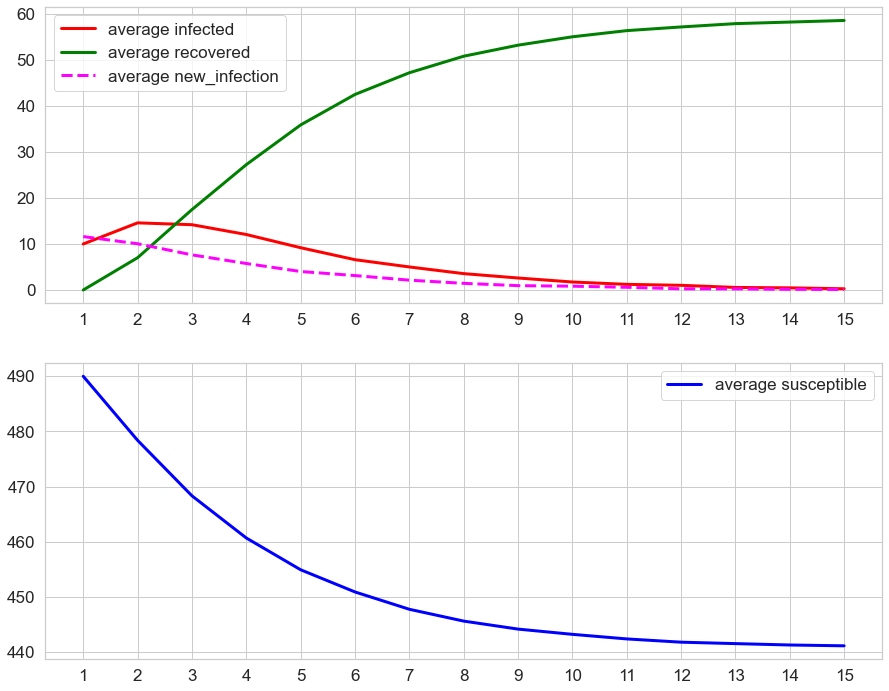

In [7]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

### Average of new infection over 15 weeks for the symmetric graph

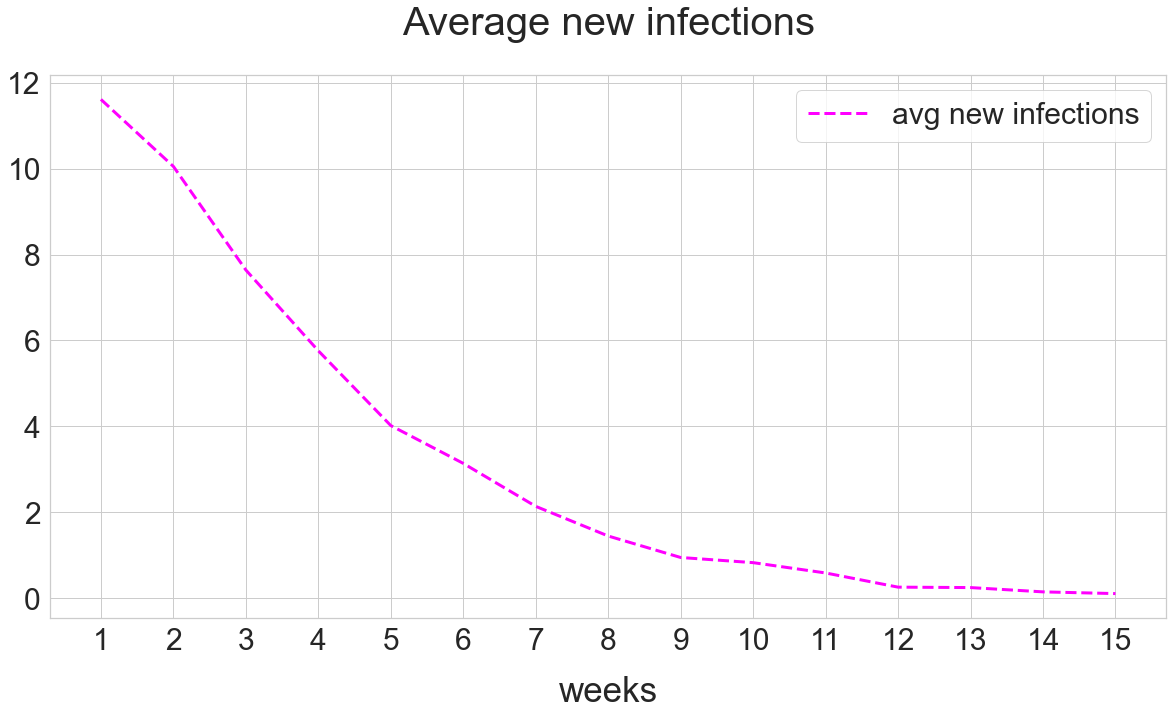

In [8]:
fig, ax1= plt.subplots(1,1,figsize=(20,10))                                                       
x = list(np.arange(1, 16))
ax1.set_xticks(x)
             

ax1.plot(x, avg_new_infection, label="avg new infections", color = 'magenta', linestyle='--'
         , linewidth=3) 


ax1.set_title("Average new infections", fontsize=40, pad=40)
ax1.set_xlabel("weeks", fontsize=35)
ax1.xaxis.labelpad = 20
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(fontsize=30)
#plt.savefig('02_avg_infected_symm.png', bbox_inches='tight')
plt.show() 

### Average of susceptible, infected, recovered over 15 weeks for the symmetric graph

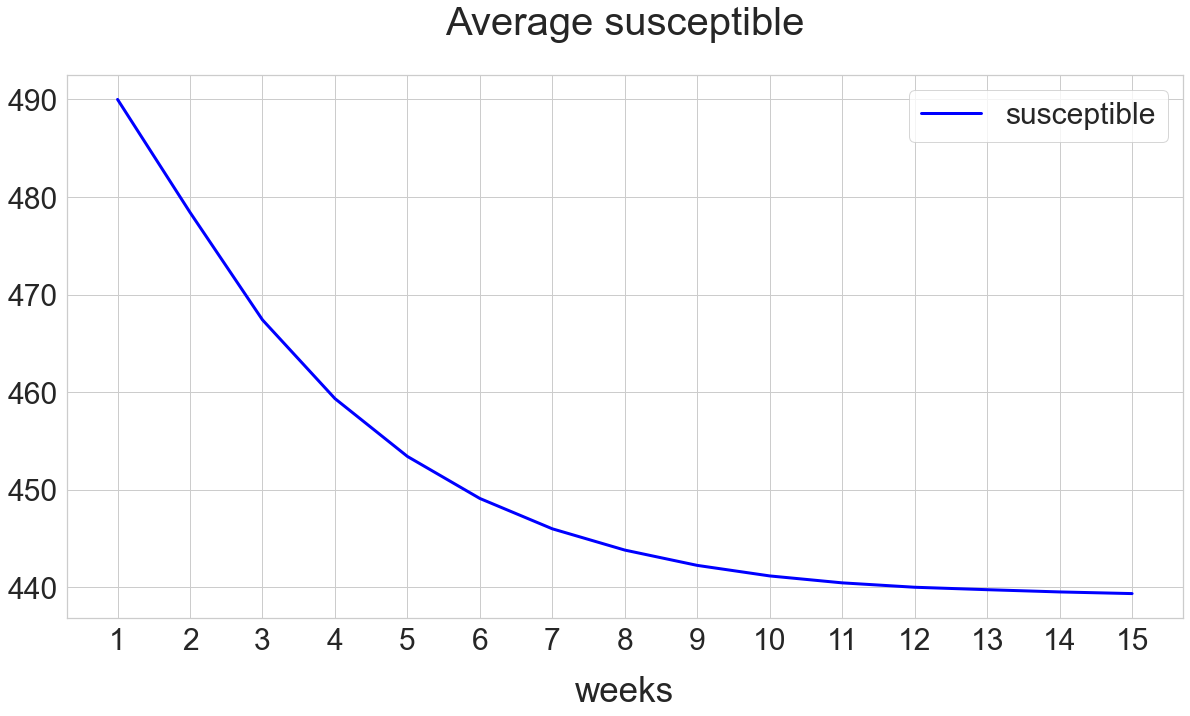

In [76]:
fig, (ax1)= plt.subplots(1,1,figsize=(20,10))
x = list(np.arange(1, 16))
ax1.set_xticks(x)
             
ax1.plot(x, avg_susceptible, label="susceptible", color = 'blue', linewidth=3) 

ax1.set_title("Average susceptible", fontsize=40, pad=40)

ax1.set_xlabel("weeks", fontsize=35)
ax1.xaxis.labelpad = 20

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(fontsize=30)

plt.savefig('03_avg_susceptible.png', bbox_inches='tight')
plt.show() 

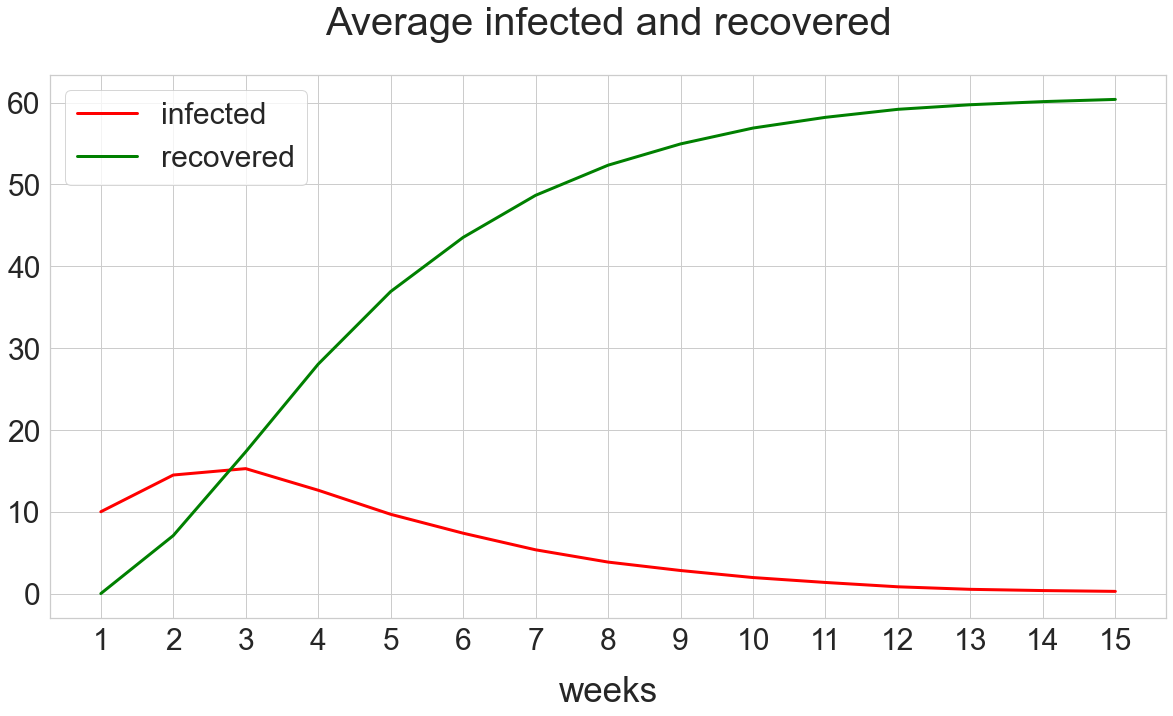

In [86]:
fig, (ax1)= plt.subplots(1,1,figsize=(20,10))
x = list(np.arange(1, 16))

ax1.set_xlabel("weeks", fontsize=35)
ax1.set_xticks(x)

             
#ax1.plot(x, avg_susceptible, label="susceptible", color = 'blue', linewidth=3) 

ax1.plot(x, avg_infected, label="infected", color = 'red', linewidth=3) 

ax1.plot(x, avg_recovered, label="recovered", color = 'green', linewidth=3) 

ax1.set_title("Average infected and recovered", fontsize=40, pad=40)

ax1.xaxis.labelpad = 20


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(fontsize=30)

plt.savefig('03_avg_inf_rec.png', bbox_inches='tight')
plt.show() 

## Problem 1.2 - Preferential Attachment Random Graph

In [104]:

def create_random_graph(n=40, k=7):
    node_colors = []
    for i in range(k+1):
        node_colors.append('lightblue')      
    
    GPA = nx.complete_graph(k+1)
    
    for i in GPA.edges():  
        GPA[i[0]][i[1]]['color'] = 'black'
    
    for node in range(k+1, n):
        if k % 2 == 1:
            # if k is uneven take alternatively the floor and ceil of the number
            if node % 2 == 0:
                d = int(np.floor(k/2))
            else:
                d = int(np.ceil(k/2))
        else:
            # k is even
            d = int(k/2)
        
        deg_PA = [d for n, d in GPA.degree()]
        probabilities = np.array(deg_PA)/sum(deg_PA)
        #print(deg_PA)
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), p=probabilities, size=d, replace=False)
        GPA.add_node(node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(node,neigh)
            GPA[node][neigh]['color'] = 'deeppink'
        
        node_colors.append('orange')      
   
    edge_colors = [GPA[u][v]['color'] for u,v in GPA.edges()]
    print(edge_colors)
    nx.draw_circular(GPA, with_labels = True, font_color='black', edge_color=edge_colors, node_color=node_colors,node_size=4000, font_size=35, width=3, arrowsize=35)
    deg_PA = [d for n, d in GPA.degree()]
    #print()
    #print("number of nodes: ", len(GPA))
    #print("average degree: ", sum(deg_PA)/len(GPA))
    
    return GPA

['black', 'black', 'black', 'black', 'black', 'black', 'black', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'black', 'black', 'deeppink', 'deeppink', 'deeppink', 'black', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink']


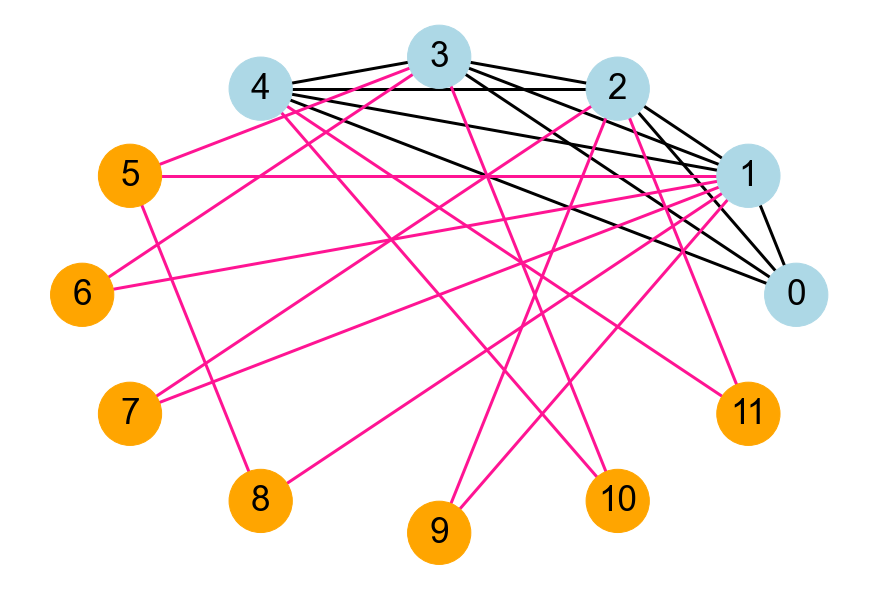

In [107]:
fig = plt.figure(1, figsize=(12,8))
create_random_graph(12, 4)
plt.savefig('04_GPA.png', bbox_inches='tight')

In [8]:
create_random_graph(910, 7)    

## Problem 2 - Simulate a pandemic without vaccination

In [12]:
G2 = create_random_graph(500, 6)  

avg susceptible:
[490.0, 473.37, 420.02, 320.56, 216.15, 148.11, 114.24, 99.78, 93.28, 90.78, 89.69, 89.09, 88.86, 88.8, 88.78]
avg infected:
[10.0, 19.62, 59.04, 117.34, 139.58, 109.68, 66.43, 34.23, 16.95, 7.51, 3.55, 1.6, 0.68, 0.31, 0.13]
avg recovered:
[0.0, 7.01, 20.94, 62.1, 144.27, 242.21, 319.33, 365.99, 389.77, 401.71, 406.76, 409.31, 410.46, 410.89, 411.09]
avg new infection:
[16.63, 53.35, 99.46, 104.41, 68.04, 33.87, 14.46, 6.5, 2.5, 1.09, 0.6, 0.23, 0.06, 0.02, 0.07]


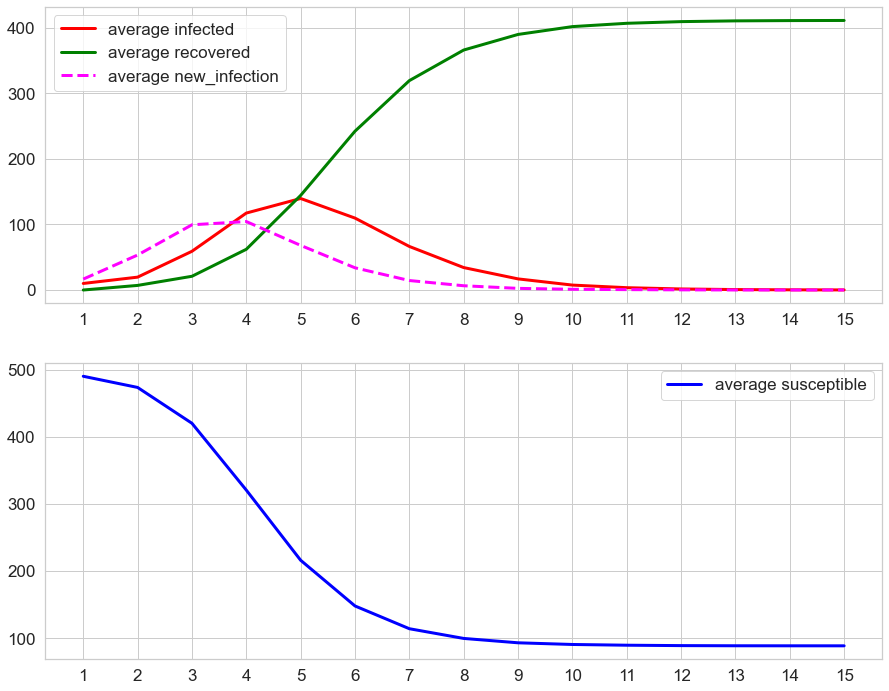

In [13]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G2)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 3 - Simulate a pandemic with vaccination

In [14]:
G3 = create_random_graph(500, 6)  

avg susceptible:
[490.0, 449.12, 356.75, 250.71, 167.51, 117.88, 87.72, 74.7, 73.47, 72.91, 72.68, 72.6, 72.56, 72.55, 72.55]
avg infected:
[10.0, 19.4, 50.26, 77.89, 70.09, 41.86, 19.13, 8.45, 3.78, 1.79, 0.81, 0.37, 0.17, 0.06, 0.01]
avg recovered:
[0.0, 6.48, 17.99, 46.4, 87.4, 115.26, 118.15, 116.85, 122.75, 125.3, 126.51, 127.03, 127.27, 127.39, 127.44]
avg vaccinated:
[0.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
avg new infection:
[17.29, 50.35, 73.01, 58.01, 28.68, 11.18, 3.58, 1.23, 0.56, 0.23, 0.08, 0.04, 0.01, 0.0, 0.0]
avg new vaccinated:
[0.0, 25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


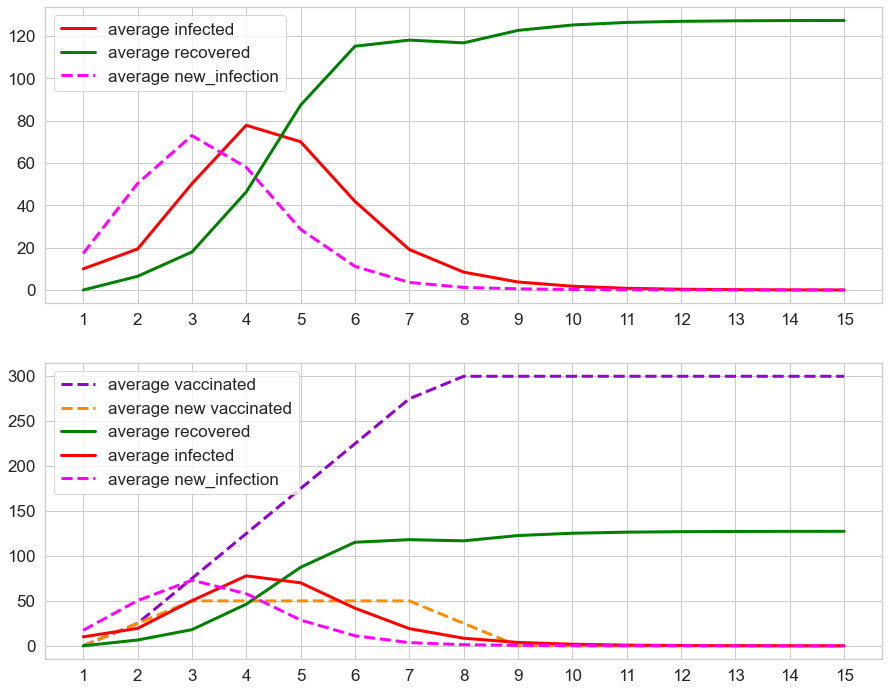

In [15]:
vax_campaign = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G3,n_infected=10, 
                                                          beta=0.3, rho=0.7, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, 
                     avg_new_infection, avg_vaccinated, avg_new_vaccinated, flg_vaccine = True)

## Problem 4 - The H1N1 pandemic in Sweden 2009

In [ ]:
#k_0 = int(np.random.rand()*20)
k_0 = 21
k_delta = 4
beta_0 = 0.3
beta_delta = 0.4
rho_0 = 0.6
rho_delta = 0.4
n_weeks=15
n_simulation = 10

vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
#true_new_infection = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
true_new_infection = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_rmse_k_b_r = (10000000, 10000000, 10000000, 10000000)

alpha = 0.5
cnt = 0
n = 6

print("k_0: ", k_0)
print()

stopping_condition = True
while(stopping_condition):
    
    prev_best_rmse_k_b_r = best_rmse_k_b_r

    k = [int(max(k_0-k_delta,1)) ,k_0 ,int(k_0+k_delta)]
    b = np.linspace(max(beta_0-beta_delta, 0.01), min(beta_0+beta_delta,1), num=n)
    r = np.linspace(max(rho_0-rho_delta, 0.01), min(rho_0+rho_delta,1), num=n)
    
        
    print("k: ", k)  
    print("b: ", b)  
    print("r: ", r)  
    print(" ")
    combinations = [k, b, r]

    # Iterate over all the possible combinations of k, beta e rho
    for c in list(itertools.product(*combinations)):

        k_c, b_c, r_c = c

        # generate a random graph
        G = create_random_graph(934, k_c) 

        # simulate epidemics over the random graph
        (avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
         avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G,n_infected=1, 
                                                              beta=b_c, rho=r_c, 
                                                              n_weeks=n_weeks, n_simulation=n_simulation,
                                                              flg_vaccine = True, 
                                                              vax_campaign = vax_campaign)

        # compute RMSE
        sqrt_diff = [(x-y)**2 for x,y in zip(avg_new_infection,true_new_infection)]
        rmse = (sum(sqrt_diff)/n_weeks)**0.5
        print_statusline("RMSE = {} - k = {} - beta = {} - rho - {}".format(rmse,k_c, b_c, r_c))
        #print()

        # compare with the best RMSE
        if rmse < best_rmse_k_b_r[0]:
            best_rmse_k_b_r = (rmse, k_c, b_c, r_c)
            
            # I found a different k
            if (best_rmse_k_b_r[1] != prev_best_rmse_k_b_r[1] or 
                best_rmse_k_b_r[2] != prev_best_rmse_k_b_r[2] or 
                best_rmse_k_b_r[3] != prev_best_rmse_k_b_r[3]):
                cnt = 0
                k_delta = 4
                beta_delta = 0.4
                rho_delta = 0.4
                n = 6

    if (best_rmse_k_b_r[1]==prev_best_rmse_k_b_r[1]  
       ):
        cnt+=1
        
        if cnt == 10:
            stopping_condition = False
           
        if cnt > 2 and cnt % 2 ==1:
            k_delta = max(k_delta*alpha,1)
            n = n + 5

    
    print_statusline("RMSE = {} - k = {} - beta = {} - rho - {}".format(best_rmse_k_b_r[0],
                                                                        best_rmse_k_b_r[1],
                                                                        best_rmse_k_b_r[2],
                                                                        best_rmse_k_b_r[3]))
    print("")
    print("")
    print("-------------------------------")
    print("counter same k: ", cnt)
    print("chosen param: ({} \xB1 {}, {} \xB1 {}, {} \xB1 {})".format(best_rmse_k_b_r[1], k_delta,
                                                  best_rmse_k_b_r[2], beta_delta, 
                                                  best_rmse_k_b_r[3], rho_delta)) 
    print("best rmse = {}".format(best_rmse_k_b_r[0])) 

    print("-------------------------------")
    print()
    k_0, beta_0, rho_0 = best_rmse_k_b_r[1], best_rmse_k_b_r[2], best_rmse_k_b_r[3]    

print(best_rmse_k_b_r)

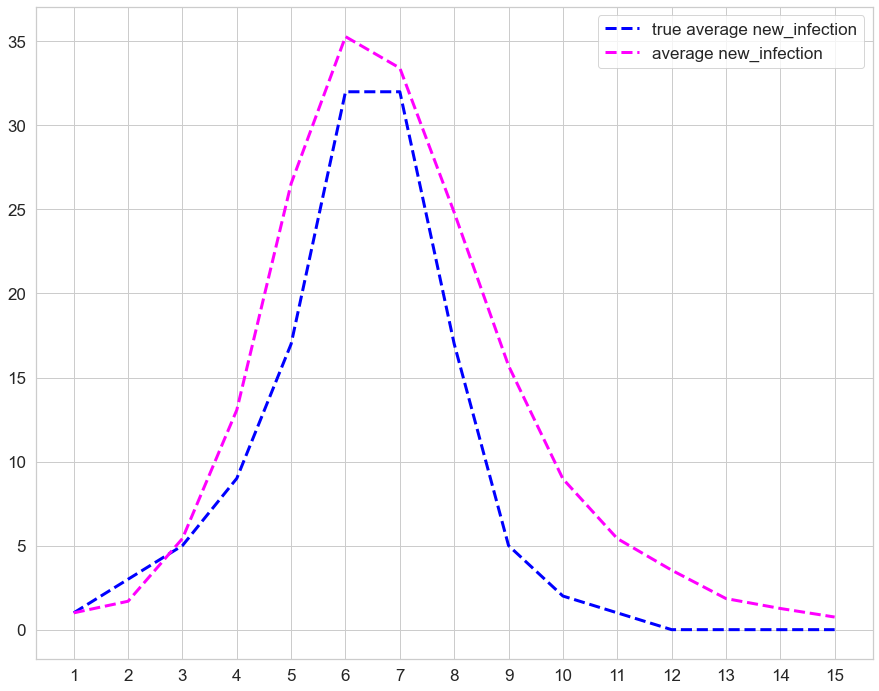

In [29]:
vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]


 

#G4 = create_random_graph(934, 21)    
#(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
# avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G4,n_infected=1, 
#                                                          beta=0.089872, rho=0.71712, 
#                                                          n_weeks=15, n_simulation=100,
#                                                          flg_vaccine = True, 
#                                                          vax_campaign = vax_campaign)

fig, ax1= plt.subplots(1,1,figsize=(15,12))
true_infection = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
x = list(np.arange(1, 16))
ax1.set_xticks(x)
             

ax1.plot(x, true_infection, label="true average new_infection", color = 'blue', linestyle='--'
         , linewidth=3) 

ax1.plot(x, tmp, label="average new_infection", color = 'magenta', linestyle='--'
         , linewidth=3) 


ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.legend(fontsize=17)

plt.show()

In [27]:
print(avg_new_infection[:-1])

[1.69, 5.42, 13.07, 26.54, 35.28, 33.41, 24.82, 15.7, 8.97, 5.42, 3.54, 1.85, 1.26, 0.75]


In [ ]:
#To save: and store
[1.69, 5.42, 13.07, 26.54, 35.28, 33.41, 24.82, 15.7, 8.97, 5.42, 3.54, 1.85, 1.26, 0.75]
tmp = [1, 1.69, 5.42, 13.07, 26.54, 35.28, 33.41, 24.82, 15.7, 8.97, 5.42, 3.54, 1.85, 1.26, 0.75]

In [45]:
sqrt_diff = [(x-y)**2 for x,y in zip(true_infection,tmp)]
rmse = (sum(sqrt_diff)/n_weeks)**0.5
print(rmse)

5.060167322661706


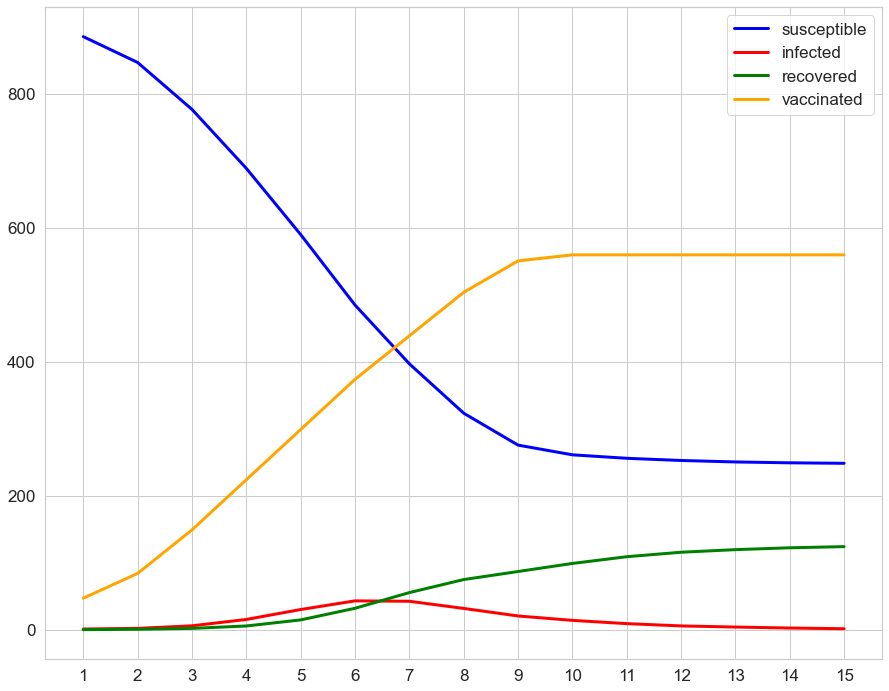

In [44]:
vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
RG = create_random_graph(934, 21)    
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(RG,n_infected=1, 
                                                          beta=0.089872, rho=0.71712, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True,
                                                          vax_campaign = vax_campaign)
                                                          
fig, ax1= plt.subplots(1,1,figsize=(15,12))                                                       
x = list(np.arange(1, 16))
ax1.set_xticks(x)
             

ax1.plot(x, avg_susceptible, label="susceptible", color = 'blue'
         , linewidth=3) 

ax1.plot(x, avg_infected, label="infected", color = 'red'
         , linewidth=3) 

ax1.plot(x, avg_recovered, label="recovered", color = 'green'
         , linewidth=3) 

ax1.plot(x, avg_vaccinated, label="vaccinated", color = 'orange'
         , linewidth=3) 


ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.legend(fontsize=17)

plt.show() 

## Below trash

In [51]:
def show_susc_infec_recov_vacc(avg_susceptible, avg_infected, avg_recovered, avg_vaccinated=[]):
    fig, ax1= plt.subplots(1,1,figsize=(15,12))                                                       
    x = list(np.arange(1, 16))
    ax1.set_xticks(x)


    ax1.plot(x, avg_susceptible, label="susceptible", color = 'blue'
             , linewidth=3) 

    ax1.plot(x, avg_infected, label="infected", color = 'red'
             , linewidth=3) 

    ax1.plot(x, avg_recovered, label="recovered", color = 'green'
             , linewidth=3) 

    if len(avg_vaccinated)>0:
        ax1.plot(x, avg_vaccinated, label="vaccinated", color = 'orange', linewidth=3) 

    ax1.tick_params(axis='x', labelsize=17)
    ax1.tick_params(axis='y', labelsize=17)
    ax1.legend(fontsize=17)

    plt.show() 

In [31]:
#k_0 = int(np.random.rand()*20)
k_0 = 21
k_delta = 4
beta_0 = 0.3
beta_delta = 0.4
rho_0 = 0.6
rho_delta = 0.4
n_weeks=15
n_simulation = 10

vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
#true_new_infection = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
true_new_infection = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_rmse_k_b_r = (10000000, 10000000, 10000000, 10000000)

alpha = 0.5
cnt = 0
n = 6

print("k_0: ", k_0)
print()

stopping_condition = True
while(stopping_condition):
    
    prev_best_rmse_k_b_r = best_rmse_k_b_r

    k = [int(max(k_0-k_delta,1)) ,k_0 ,int(k_0+k_delta)]
    b = np.linspace(max(beta_0-beta_delta, 0.01), min(beta_0+beta_delta,1), num=n)
    r = np.linspace(max(rho_0-rho_delta, 0.01), min(rho_0+rho_delta,1), num=n)
    
        
    print("k: ", k)  
    print("b: ", b)  
    print("r: ", r)  
    print(" ")
    combinations = [k, b, r]

    # Iterate over all the possible combinations of k, beta e rho
    for c in list(itertools.product(*combinations)):

        k_c, b_c, r_c = c

        # generate a random graph
        RG = nx.random_regular_graph(k_c, 934) 

        # simulate epidemics over the random graph
        (avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
         avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(RG,n_infected=1, 
                                                              beta=b_c, rho=r_c, 
                                                              n_weeks=n_weeks, n_simulation=n_simulation,
                                                              flg_vaccine = True, 
                                                              vax_campaign = vax_campaign)

        # compute RMSE
        sqrt_diff = [(x-y)**2 for x,y in zip(avg_new_infection,true_new_infection)]
        rmse = (sum(sqrt_diff)/n_weeks)**0.5
        print_statusline("RMSE = {} - k = {} - beta = {} - rho - {}".format(rmse,k_c, b_c, r_c))
        #print()

        # compare with the best RMSE
        if rmse < best_rmse_k_b_r[0]:
            best_rmse_k_b_r = (rmse, k_c, b_c, r_c)
            
            # I found a different k
            if (best_rmse_k_b_r[1] != prev_best_rmse_k_b_r[1] or 
                best_rmse_k_b_r[2] != prev_best_rmse_k_b_r[2] or 
                best_rmse_k_b_r[3] != prev_best_rmse_k_b_r[3]):
                cnt = 0
                k_delta = 4
                beta_delta = 0.4
                rho_delta = 0.4
                n = 6

    if (best_rmse_k_b_r[1]==prev_best_rmse_k_b_r[1]  
       ):
        cnt+=1
        
        if cnt == 10:
            stopping_condition = False
           
        if cnt > 2 and cnt % 2 ==1:
            k_delta = max(k_delta*alpha,1)
            n = n + 5

    
    print_statusline("RMSE = {} - k = {} - beta = {} - rho - {}".format(best_rmse_k_b_r[0],
                                                                        best_rmse_k_b_r[1],
                                                                        best_rmse_k_b_r[2],
                                                                        best_rmse_k_b_r[3]))
    print("")
    print("")
    print("-------------------------------")
    print("counter same k: ", cnt)
    print("chosen param: ({} \xB1 {}, {} \xB1 {}, {} \xB1 {})".format(best_rmse_k_b_r[1], k_delta,
                                                  best_rmse_k_b_r[2], beta_delta, 
                                                  best_rmse_k_b_r[3], rho_delta)) 
    print("best rmse = {}".format(best_rmse_k_b_r[0])) 

    print("-------------------------------")
    print()
    k_0, beta_0, rho_0 = best_rmse_k_b_r[1], best_rmse_k_b_r[2], best_rmse_k_b_r[3]    

print(best_rmse_k_b_r)

k_0:  21

k:  [17, 21, 25]
b:  [0.01  0.148 0.286 0.424 0.562 0.7  ]
r:  [0.2  0.36 0.52 0.68 0.84 1.  ]
 
RMSE = 4.9372056874308985 - k = 17 - beta = 0.148 - rho - 1.0                              

-------------------------------
counter same k:  0
chosen param: (17 ± 4, 0.148 ± 0.4, 1.0 ± 0.4)
best rmse = 4.9372056874308985
-------------------------------

k:  [13, 17, 21]
b:  [0.01   0.1176 0.2252 0.3328 0.4404 0.548 ]
r:  [0.6  0.68 0.76 0.84 0.92 1.  ]
 
RMSE = 4.822171018673367 - k = 21 - beta = 0.1176 - rho - 0.84               

-------------------------------
counter same k:  0
chosen param: (21 ± 4, 0.1176 ± 0.4, 0.84 ± 0.4)
best rmse = 4.822171018673367
-------------------------------

k:  [17, 21, 25]
b:  [0.01    0.11152 0.21304 0.31456 0.41608 0.5176 ]
r:  [0.44  0.552 0.664 0.776 0.888 1.   ]
 
RMSE = 4.822171018673367 - k = 21 - beta = 0.1176 - rho - 0.84                             

-------------------------------
counter same k:  1
chosen param: (21 ± 4, 0.1176 ± 0.

RMSE = 3.93234450847498 - k = 26 - beta = 0.11006079999999999 - rho - 0.80352               

-------------------------------
counter same k:  5
chosen param: (26 ± 1.0, 0.11006079999999999 ± 0.4, 0.80352 ± 0.4)
best rmse = 3.93234450847498
-------------------------------

k:  [25, 26, 27]
b:  [0.01       0.04333739 0.07667477 0.11001216 0.14334955 0.17668693
 0.21002432 0.24336171 0.27669909 0.31003648 0.34337387 0.37671125
 0.41004864 0.44338603 0.47672341 0.5100608 ]
r:  [0.40352    0.44328533 0.48305067 0.522816   0.56258133 0.60234667
 0.642112   0.68187733 0.72164267 0.761408   0.80117333 0.84093867
 0.880704   0.92046933 0.96023467 1.        ]
 
RMSE = 3.93234450847498 - k = 26 - beta = 0.11006079999999999 - rho - 0.80352               

-------------------------------
counter same k:  6
chosen param: (26 ± 1.0, 0.11006079999999999 ± 0.4, 0.80352 ± 0.4)
best rmse = 3.93234450847498
-------------------------------

k:  [25, 26, 27]
b:  [0.01       0.04333739 0.07667477 0.11001216

In [ ]:
-------------------------------
counter same k:  10
chosen param: (26 ± 1, 0.11006079999999999 ± 0.4, 0.80352 ± 0.4)
best rmse = 3.93234450847498
-------------------------------


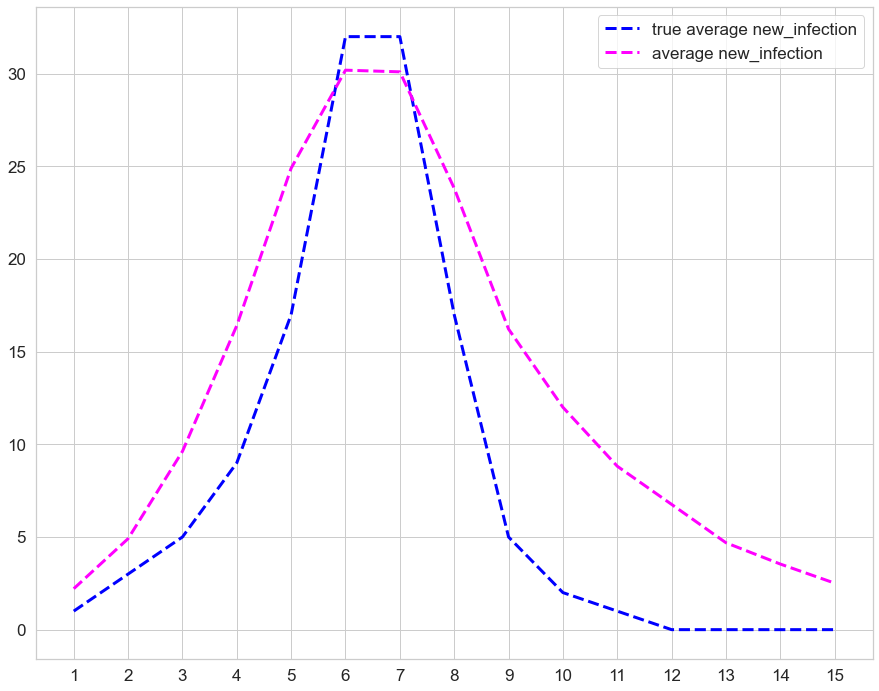

In [39]:
G5=nx.random_regular_graph(23, 934)

vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
   
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G5,n_infected=1, 
                                                          beta=0.11006079999999999, rho=0.80352, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

fig, ax1= plt.subplots(1,1,figsize=(15,12))
true_infection = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
x = list(np.arange(1, 16))
ax1.set_xticks(x)
             

ax1.plot(x, true_infection, label="true average new_infection", color = 'blue', linestyle='--'
         , linewidth=3) 

ax1.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
         , linewidth=3) 


ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.legend(fontsize=17)

plt.show()